In [1]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import display, HTML
import ipywidgets

# Seed for random number generation...
# Set to None to seed the random number
# generator with a random seed...
SEED = 12903614

# Colorblindness friendly colours...
# It is important to make our work
# as accessible as possible...
COLORMAP = ["#005AB5", "#DC3220"]

# Template settings for plotly...
layout_axis = dict(
    mirror=True,
    ticks="outside",
    showline=True,
    title_standoff = 5,
    showgrid = True,
)
pio.templates["DrJohnWagner"] = go.layout.Template(
    layout_xaxis = layout_axis,
    layout_yaxis = layout_axis,
    layout_title_font_size = 18,
    layout_font_size = 16,
)
pio.templates.default = "simple_white+DrJohnWagner"

In [2]:
# Loading the data from the csv file...
df = pd.read_csv('./input/heart.csv')
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [3]:
# Fix the egregious column naming error...
df = df.rename(columns = {"ST_Slope": "STSlope", "Oldpeak": "OldPeak"})

# Always test these things...
assert len(df["STSlope"]) > 0, "Ruh roh! ST_Slope is still terribly mistaken!"
assert len(df["OldPeak"]) > 0, "Ruh roh! Oldpeak is still terribly mistaken!"

df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  OldPeak STSlope  HeartDisease  
0              N      0.0      Up             0  
1              N      1.0    Flat             1  
2              N      0.0      Up             0  
3              Y      1.5    Flat             1  
4              N      0.0      Up             0

In [4]:
# Break the columns into two groupings...
categorical_columns = [column for column in df.columns if df[column].dtypes =='O']
numerical_columns = [column for column in df.columns if df[column].dtypes != 'O']

# Now that we've got the column names fixed
# let's define some labels for later...
LABELS = {
    "Sex": "Sex",
    "Age": "Age",
    "MaxHR": "Max HR",
    "OldPeak": "Old Peak",
    "STSlope": "ST Slope",
    "RestingBP": "Rest. BP",
    "FastingBS": "Fast. BS",
    "RestingECG": "Rest. ECG",
    "Cholesterol": "Cholesterol",
    "HeartDisease": "Heart Disease",
    "ChestPainType": "Chest Pain",
    "ExerciseAngina": "Ex. Angina",
    # For playing with classes...
    "AgeClass": "Age Class",
    "CholesterolClass": "Cholesterol Class",
    "RestingBPClass": "Resting BP Class",
}

In [5]:
display(df.iloc[0:2, :][numerical_columns])

Age  RestingBP  Cholesterol  FastingBS  MaxHR  OldPeak  HeartDisease
0   40        140          289          0    172      0.0             0
1   49        160          180          0    156      1.0             1

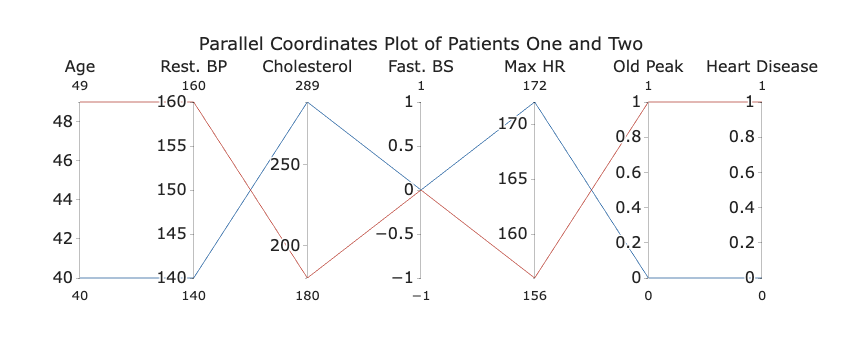

In [6]:
# We will make a lot of parallel coordinates plots
# so let's wrap the calls in a simple function that
# creates a plotly.graph_objects.Parcoords object
# to display our data in parallel coordinates...
def create_parallel_coordinates_plot(df, color, columns):
    return go.Parcoords(
        dimensions = list([
            dict(
                values = df[column],
                label = LABELS[column],
                name = column,
            ) for column in columns
        ]),
        line = dict(
            color = df["HeartDisease"],
            colorscale = COLORMAP,
            showscale = False
        ),
        labelfont = dict( size = 16 ),
        tickfont = dict( size = 16 ),
    )

def create_layout(title):
    return go.Layout(
        title = go.layout.Title(
            text = title,
            x = 0.5,
            xanchor = "center"
        )
    )

# Wrap the plotly.graph_objects.Parcoords object
# in a plotly.graph_objects.Figure object...
fig_one = go.Figure(
    create_parallel_coordinates_plot(
        df.iloc[0:2, :], "HeartDisease", numerical_columns
    ),
    layout = create_layout("Parallel Coordinates Plot of Patients One and Two"),
)
# And show() the figure!
fig_one.show()

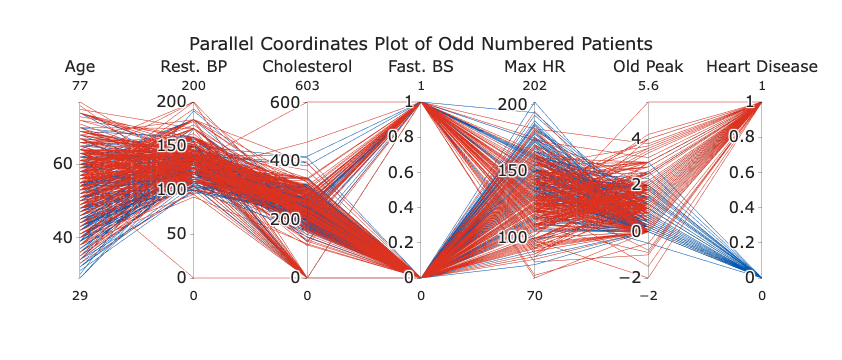

In [7]:
# Plot the numerical columns of the dataset
# colour coded by HeartDisease with red = true...
# Plot every other row starting at one to
# reduce data for better visibility...
fig_two = go.Figure(
    create_parallel_coordinates_plot(
        df.iloc[1::2, :], "HeartDisease", numerical_columns
    ),
    layout = create_layout("Parallel Coordinates Plot of Odd Numbered Patients"),
)

# Show the plot!
fig_two.show()

In [8]:
#We will set those values to random samples drawn from a uniform distribution approximating the rest of the values in those columns:

def set_column_value_to_normal_distribution(df, column, value):
    # Compute the column's mean and standard deviation
    # after removing rows whose column matches value...
    mean_value = df[df[column] != value][column].mean()
    std_value  = df[df[column] != value][column].std()
    # Create a random number generator...
    rng = np.random.default_rng(SEED)
    # Now set the column of those rows to a
    # random sample from a normal distribution...
    df[column] = df[column].apply(
        lambda x : rng.normal(mean_value, std_value) if x == value else x
    )
    return df

df = set_column_value_to_normal_distribution(df, "RestingBP"  , 0)
df = set_column_value_to_normal_distribution(df, "Cholesterol", 0)

# Always test...
assert len(df[df["RestingBP"  ] == 0]) == 0, "Ruh roh! One or more patients has crashed again!"
assert len(df[df["Cholesterol"] == 0]) == 0, "Ruh roh! One or more patients has crashed again!"

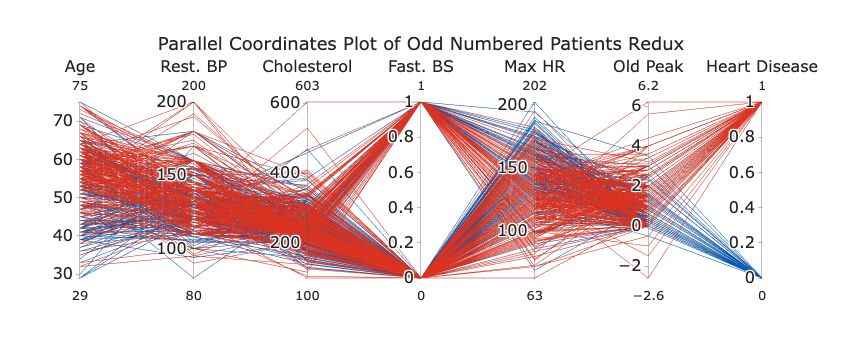

In [9]:
# Let's shuffle the data to ensure
# we get a random selection of data
df = shuffle(df)

# Regenerate the figure...
fig_three = go.Figure(
    create_parallel_coordinates_plot(
        df.iloc[1::2, :], "HeartDisease", numerical_columns
    ),
    layout = create_layout("Parallel Coordinates Plot of Odd Numbered Patients Redux"),
)

# And show and tell time!
fig_three.show()

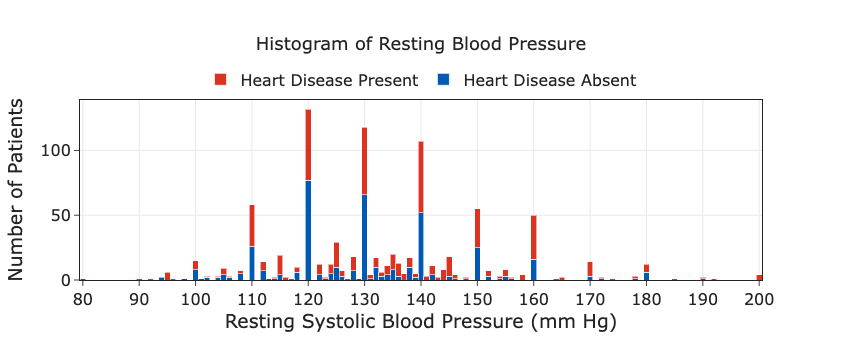

In [10]:
from plotly.subplots import make_subplots

def create_histogram_plot(df, heart_disease, column, name):
    return go.Histogram(
        x = df[df["HeartDisease"] == heart_disease][column],
        name = name,
        marker_color = COLORMAP[heart_disease],
        xbins = dict(
            start = int(np.min(df[column])) - 0.5,
            end   = int(np.max(df[column])) + 0.5,
            size = 1.0
        )
    )

fig_four_bp = go.Figure(
    layout = create_layout("Histogram of Resting Blood Pressure"),
)
fig_four_bp.add_trace(
    create_histogram_plot(df, 0, "RestingBP", "Heart Disease Absent")
)
fig_four_bp.add_trace(
    create_histogram_plot(df, 1, "RestingBP", "Heart Disease Present")
)

min_bp, max_bp = int(np.min(df["RestingBP"])), int(np.max(df["RestingBP"]))
fig_four_bp.update_layout(
    barmode = "stack",
    xaxis_tickvals = np.arange(min_bp, max_bp + 1, 10),
    xaxis_title_text = "Resting Systolic Blood Pressure (mm Hg)",
    yaxis_title_text = "Number of Patients",
    legend = dict(
        orientation = "h", yanchor = "bottom", y = 1.02, xanchor = "center", x = 0.5
    )
)

# Show the plot!
fig_four_bp.show()

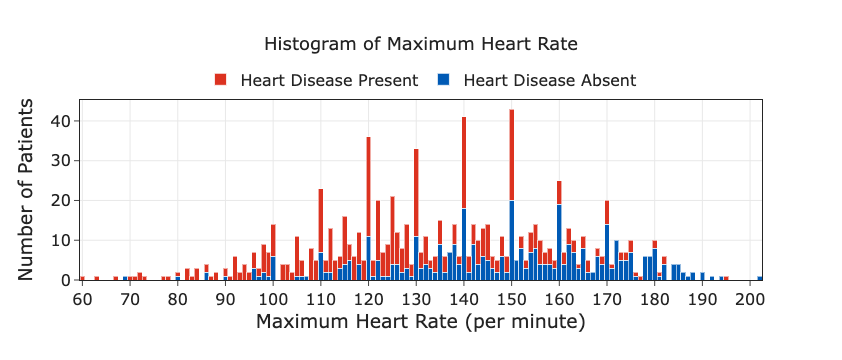

In [11]:
from plotly.subplots import make_subplots

fig_four_hr = go.Figure(
    layout = create_layout("Histogram of Maximum Heart Rate"),
)
fig_four_hr.add_trace(
    create_histogram_plot(df, 0, "MaxHR", "Heart Disease Absent")
)
fig_four_hr.add_trace(
    create_histogram_plot(df, 1, "MaxHR", "Heart Disease Present")
)

min_hr, max_hr = int(np.min(df["MaxHR"])), int(np.max(df["MaxHR"]))
fig_four_hr.update_layout(
    barmode = "stack",
    xaxis_tickvals = np.arange(min_hr, max_hr + 1, 10),
    xaxis_title_text = "Maximum Heart Rate (per minute)",
    yaxis_title_text = "Number of Patients",
    legend = dict(
        orientation = "h", yanchor = "bottom", y = 1.02, xanchor = "center", x = 0.5
    )
)

# Show the plot!
fig_four_hr.show()

In [12]:
# Let's move FastingBS from numerical_columns
# to categorical_columns and add HeartDisease
# to categorical_columns...
if "FastingBS" not in categorical_columns:
    categorical_columns.append("FastingBS")
if "HeartDisease" not in categorical_columns:
    categorical_columns.append("HeartDisease")
if "FastingBS" in numerical_columns:
    numerical_columns.remove("FastingBS")

assert "FastingBS" not in numerical_columns, "FastingBS not removed from numerical columns..."
assert "FastingBS" in categorical_columns, "FastingBS not added to categorical columns..."
assert "HeartDisease" in categorical_columns, "HeartDisease not added to categorical columns..."

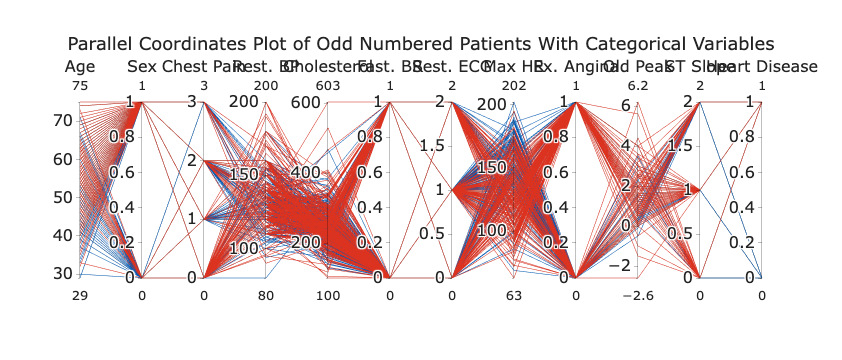

In [13]:
df_copy = df.copy()
label_encoder = LabelEncoder()
for column in ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "STSlope"]:
    df_copy[column] = label_encoder.fit_transform(df_copy[column])

fig_five = go.Figure(
    create_parallel_coordinates_plot(
        df_copy[1::2], "HeartDisease", list(df_copy)
    ),
    layout = create_layout("Parallel Coordinates Plot of Odd Numbered Patients With Categorical Variables"),
)

# Show the plot!
fig_five.show()

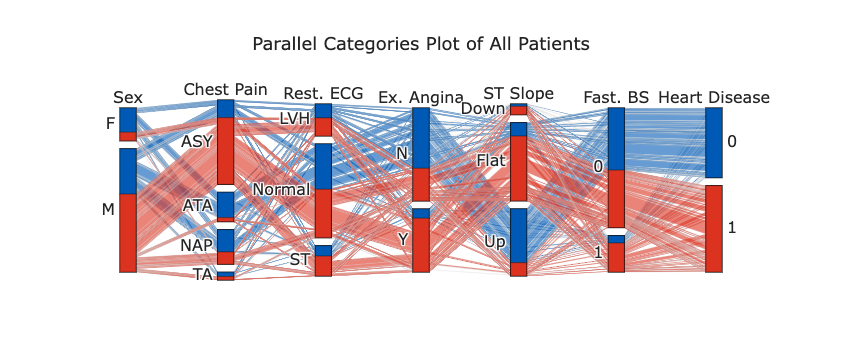

In [14]:
# We will make a lot of parallel categories plots
# so let's wrap the calls in a simple function...
def create_parallel_categoriess_plot(df, color, columns, labels = LABELS):
    return go.Parcats(
        line = dict(color = df['HeartDisease'], colorscale = COLORMAP, showscale = False),
        dimensions = list([
            dict(
                label = labels[column],
                values = df[column],
                categoryorder = "category ascending"
            ) for column in columns
        ]),
        labelfont = dict( size = 16 ),
        tickfont = dict( size = 16 ),
    )

fig_six = go.Figure(
    create_parallel_categoriess_plot(df, "HeartDisease", categorical_columns),
    layout = create_layout("Parallel Categories Plot of All Patients"),
)

# Show the plot!
fig_six.show()

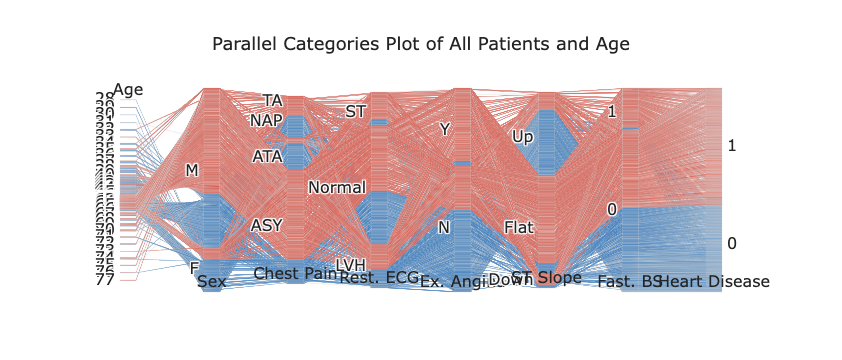

In [15]:
fig_seven = go.Figure(
    create_parallel_categoriess_plot(
        df, "HeartDisease", ["Age"] + categorical_columns
    ),
    layout = create_layout("Parallel Categories Plot of All Patients and Age"),
)

# Show the plot!
fig_seven.show()

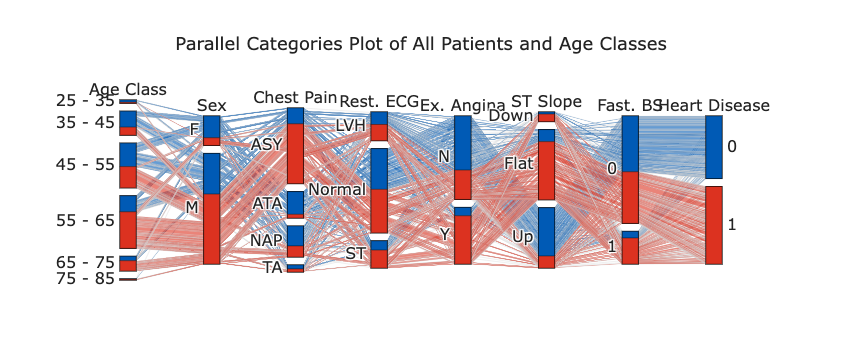

In [16]:
def create_categories_from_values(df, column, resolution = 10, offset = 0):
    return df[column].apply(
        lambda x : str(
            int(resolution*((x - offset) // resolution) + offset)
        ) + " - " + str(
            int(resolution*(1 + (x - offset) // resolution) + offset)
        )
    )

df_copy = df.copy()
df_copy["AgeClass" ] = create_categories_from_values(df_copy, "Age", 10, 5)

fig_eight = go.Figure(
    create_parallel_categoriess_plot(
        df_copy, "HeartDisease", ["AgeClass"] + categorical_columns
    ),
    layout = create_layout("Parallel Categories Plot of All Patients and Age Classes"),
)

# Turn off the colorbar...it's useless...
fig_eight.update_layout(coloraxis_showscale = False)
# fig.update_layout(yaxis_autorange = "reversed")
# fig['layout']['yaxis']['autorange'] = "reversed"
# Show the plot!
fig_eight.show()

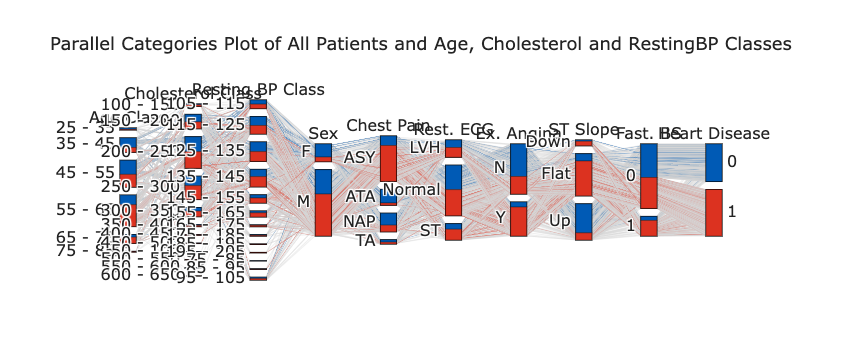

In [17]:
df_copy["CholesterolClass" ] = create_categories_from_values(df_copy, "Cholesterol", 50, 0)
df_copy["RestingBPClass" ] = create_categories_from_values(df_copy, "RestingBP", 10, 5)

fig_nine = go.Figure(
    create_parallel_categoriess_plot(
        df_copy, "HeartDisease", ["AgeClass", "CholesterolClass", "RestingBPClass"] + categorical_columns
    ),
    layout = create_layout("Parallel Categories Plot of All Patients and Age, Cholesterol and RestingBP Classes"),
)

# Turn off the colorbar...it's useless...
fig_nine.update_layout(coloraxis_showscale = False)
# fig.update_layout(yaxis_autorange = "reversed")
# fig['layout']['yaxis']['autorange'] = "reversed"
# Show the plot!
fig_nine.show()

In [ ]:
categorical_columns.remove("HeartDisease")
categorical_columns = ["HeartDisease"] + categorical_columns
numerical_columns.remove("Age")
numerical_columns.remove("HeartDisease")
numerical_columns = numerical_columns + ["Age", "HeartDisease"]